I learned about the mushroom dataset recently.
This dataset taught me a lesson worthy sharing, and this is what I would like to do in this notebook.
I hope the examples below will help you:

* Get started with decision trees
* Understand better some of the possible tunings
* Learn about a common pitfall

## Exploring the Mushrooms dataset

You can find the dataset [here](https://archive.ics.uci.edu/ml/datasets/Mushroom).
The main objective is to predict what is the class of the mushroom; is it edible or poisons.
<img src="files/{filename}/images/mushroom-ml.jpg" alt="Mushroom" style="width: 200px;"/>

So, let's get started!
Let us start with the must-have includes; we will include further modules later upon need.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot') # Have a nicer style of the plots

[Pandas](http://pandas.pydata.org/) provides an easy and straightforward API to read the CSV into a [`DataFrame`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html).
The as obtained from the repository above doesn't have headers, therefore I created a [new CSV](https://gist.github.com/drorata/d271aaa75a2322ad70617fe0fd5e4b92) which is ready for importing.

In [2]:
df = pd.read_csv('./mushrooms.csv')

Probably, the very first step is to have a look at the data:

In [3]:
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


It seems like all features have categorical values.
This can also be validated if you look at the description of the dataset.

What are we facing? 
The data size is

In [4]:
df.shape

(8124, 23)

That is, we have 8K rows and 23 features. Nice.

Should we be handling missing data?

In [5]:
pd.isnull(df).values.any()

False

Next, it is important to figure out what are the classes we have.

In [6]:
df['class'].value_counts()

e    4208
p    3916
Name: class, dtype: int64

Indeed, each mushroom has one of two classes `e` for edible and `p` for poisons.

Next, let's check how many values each attribute has

In [7]:
[df[x].unique().shape[0] for x in df.columns]

[2, 6, 4, 10, 2, 9, 2, 2, 2, 12, 2, 5, 4, 4, 9, 9, 1, 4, 3, 5, 9, 6, 7]

Not too bad.

For the sake of simplicity, we split the `DataFrame` into the target and attributes denoted as `Y` and `X`, respectively.

In [8]:
Y = df['class']
X = df[df.columns[1:]]

Since the data we have is categorical it is very standard and recommended to use the dummy representation.
You can read more either [here (wiki)](https://en.wikipedia.org/wiki/Categorical_variable) or [here (Pandas)](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) to learn a little more.

In [9]:
X_dummy = pd.get_dummies(X)

In [10]:
Y_dummy = Y.apply(lambda x: 1 if x=='e' else 0)

We can understand the structure of the dummy version of `X` by looking into a specific column.
The `bruises` column has two possible categorical values:

In [11]:
df.bruises.unique()

array(['t', 'f'], dtype=object)

In turn, in `X_dummy` there are two columns related to `df.bruises`:

* `X_dummy.bruises_t`
* `X_dummy.bruises_f`

The entry in `X_dummy` corresponding to an entry in `X` that had `t` as the value for `bruises` will have `1` and `0` in the columns `bruises_t` and `bruises_f`, respectively.

OK, time to do some ML!

## Trees training


A simple and very efficient starting point is a decision tree.
We will start with defaults and try to improve.

In [12]:
from sklearn import tree

The first step is to split the dataset into training sets (independent data and target) and to testing sets.
We first take the most naive approach, for training we will take the first $n$ lines and for testing the rest.

In [13]:
def naive_split(X, Y, n):
    # Take first n lines of X and Y for training and the rest for testing
    X_train = X[:n]
    X_test  = X[n:]
    Y_train = Y[:n]
    Y_test  = Y[n:]
    return (X_train, X_test, Y_train, Y_test)

In [14]:
def train_model(n=7000):
    # Given X_dummy and Y_dummy, split naively into training and testing sets
    X_train, X_test, Y_train, Y_test = naive_split(X_dummy, Y_dummy, n)
    # Instantiate a default decision tree with fixed random state
    # NOTE: In real life you'd probably want to remove the fixed seed.
    clf = tree.DecisionTreeClassifier(random_state=42)
    # Next, train a default decision tree using the training sets
    clf = clf.fit(X_train, Y_train)
    # Lastly, return the test sets and the trained model
    return (X_test, Y_test, clf)

Let's inspect how this works.
`train_model()` returns a triple, `X_test` and `Y_test` are the test sets obtained by a naive split of the data.
`clf` is a decision tree model trained on the training sets.
Lastly, `n` determines how many points to take for the training sets.
Here is a simple usage:

In [15]:
# Example using the default n=7000
X_test, Y_test, clf = train_model()

For example, we can predict the class of the first point in the test set:

In [16]:
clf.predict(X_test[0:1]).tolist()[0]

0

And compare it to the real value:

In [17]:
Y_test[0:1].tolist()[0]

0

In this case, the tree managed to predict the right class of the mushroom.

Next, we need to properly evaluate the tree.
To that end we load the `metrics` module:

In [18]:
import sklearn.metrics as metrics

As part of the testing we will preform an experiment.
We will take training sets of increasing sizes and evaluate the [*accuracy*](https://en.wikipedia.org/wiki/Accuracy_and_precision) (which is the score in the case of a decision tree), [*precision*](https://en.wikipedia.org/wiki/Precision_and_recall#Precision) and the [*recall*](https://en.wikipedia.org/wiki/Precision_and_recall#Recall) for each iteration.

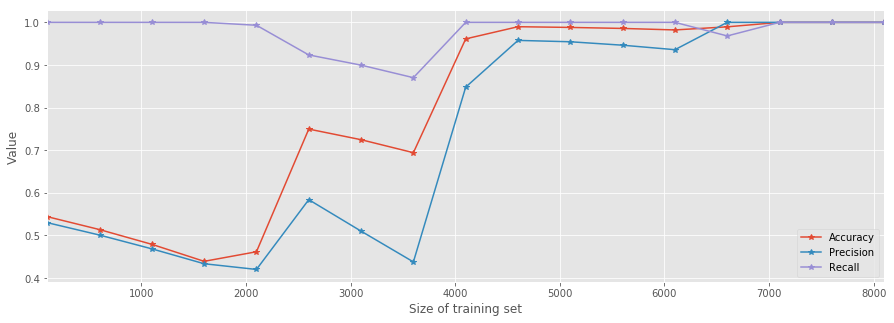

In [19]:
sizes = np.arange(100,len(Y_dummy), 500)
result = {}
for size in sizes:
    X_test, Y_test, clf = train_model(n=size)
    score     = clf.score(X_test, Y_test)
    precision = metrics.precision_score(Y_test, clf.predict(X_test))
    recall    = metrics.recall_score(Y_test, clf.predict(X_test))
    result[size] = (score, precision, recall)
# Turn the results into a DataFrame
# Transposing is needed (you tryout without it)
result = pd.DataFrame(result).transpose()
result.columns = ['Accuracy', 'Precision', 'Recall']
result.plot(marker='*', figsize=(15,5))
plt.xlabel('Size of training set')
plt.ylabel('Value');

As you can see, as soon as the training set's size $n>5000$ all metrics suggest that the model is a good predictor.
However, the improvement is very bumpy. 
This should suggest that we have to further improve something as this behavior contradicts the reasonable expectation that the model's performance will improve in a "monotonic" manner.

To that end, we will try random generation of the training and testing sets.
This can be easily done using the [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) method from the `model_selection` module.
Similarly, we will train trees using generated training sets of increasing sizes.
In turn, we will evaluate the performances of the trees like before.

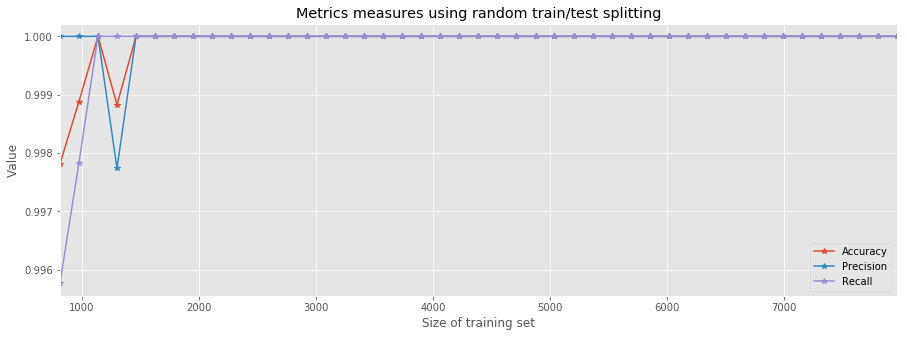

In [20]:
from sklearn import model_selection
sizes = np.arange(0.9,0.01, -0.02)
result = {}
for size in sizes:
    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(
        X_dummy, Y_dummy, test_size=size, random_state=42)
    clf = tree.DecisionTreeClassifier(random_state=42)
    clf = clf.fit(X_train, Y_train)
    score     = clf.score(X_test, Y_test)
    precision = metrics.precision_score(Y_test, clf.predict(X_test))
    recall    = metrics.recall_score(Y_test, clf.predict(X_test))
    result[len(Y_train)] = (score, precision, recall)
# Turn the results into a DataFrame
# Transposing is needed (you can tryout without it)
result = pd.DataFrame(result).transpose()
result.columns = ['Accuracy', 'Precision', 'Recall']
result.plot(marker='*', figsize=(15,5))
plt.title('Metrics measures using random train/test splitting')
plt.xlabel('Size of training set')
plt.ylabel('Value');

It is worthy trying to think what is the reason behind this significant improvement.
It seems like there's some hidden order in the rows of the dataset.
By simply counting the number of poisonous vs. edible mushrooms in the first $n$-rows, we can indeed see that, at first, the dataset contains more edible samples.

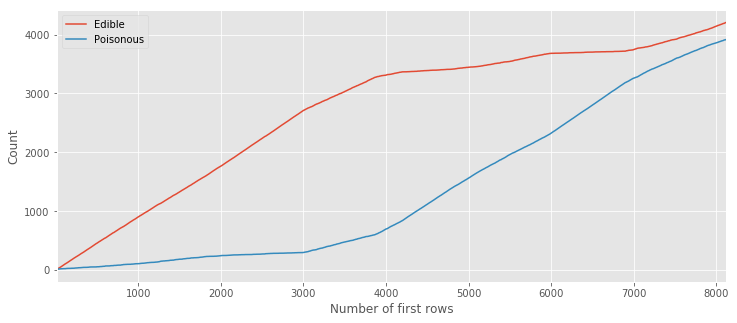

In [21]:
# Counting e(i) and p(i), the number of edible and poisonous mushrums up to the i-th row
e = []
p = []
for i in range(10,len(Y)):
    tmp = Y[:i].value_counts()
    e.append(tmp['e'])
    p.append(tmp['p'])
type_count = pd.DataFrame({'Edible': e, 'Poisonous': p},index=range(10,len(Y_dummy)))
type_count.plot(figsize=(12,5))
plt.xlabel('Number of first rows');
plt.ylabel('Count');

This image clearly shows us that the majority of samples up to the ~6000th line are edible.
This can be better visualized (known as stacked area) as follows:

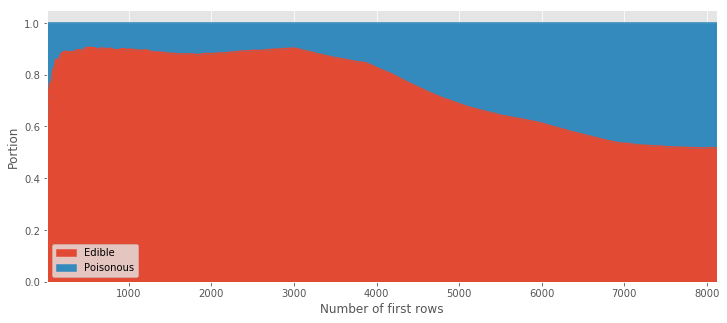

In [22]:
type_count.divide(type_count.sum(axis=1), axis=0).plot.area(figsize=(12,5))
plt.xlabel('Number of first rows')
plt.ylabel('Portion');

From this visualization you can easily see that more than $70\%$ of the first $5000$ data points are edible.
This order (or lack of randomness 🤔) explains why training the trees using the first $n$ rows is a bad idea as it trains mostly using edible examples and fails to learn the characteristics of the poisonous ones.
The **take home message** from this example: *"take a random sub-sample for the training/test split"*.

## Explore tree settings
So far we trained the tree model using the default parameters.
It is now worthwhile to explore some of the parameters that can be tuned.
To that end, let us naively take the first 2800 row for training and the rest for testing.
I chose this number by trail and error; trying to find a number for which the defaults yield nice results with room for improvement.

In [23]:
X_train, X_test, Y_train, Y_test = naive_split(X_dummy, Y_dummy, 2800)

Furthermore, we use the following simple function.
As an input it takes a model's instance and training/testing sets.
Next it computes the score, precision and recall of the model.

In [24]:
def test_tree(clf, X_train, X_test, Y_train, Y_test, print_res=True):
    clf       = clf.fit(X_train, Y_train)
    score     = clf.score(X_test, Y_test) # In the decision tree's classifier case it is the mean accuracy
    precision = metrics.precision_score(Y_test, clf.predict(X_test))
    recall    = metrics.recall_score(Y_test, clf.predict(X_test))
    res = (score, precision,recall)
    if print_res:
        print("Accuracy = %f / Precision = %f / Recall = %f" % res)
    return res

Let's recall what's the performance of the model using the [defaults](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) (for the sake of clarity, the defaults are explicitly stated).

In [25]:
clf = tree.DecisionTreeClassifier(
    criterion='gini', 
    splitter='best', 
    max_depth=None, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, 
    max_features=None, 
    random_state=42, # we override the default here for the sake of reproducibility
    max_leaf_nodes=None, 
    min_impurity_split=1e-07, 
    class_weight=None, 
    presort=False)
test_tree(clf, X_train, X_test, Y_train, Y_test);

Accuracy = 0.740045 / Precision = 0.555077 / Recall = 0.914843


### `max_features` parameter

The number of features we have in our dataset equals the number of dummy features.
We will now look into the influence of this parameter on the performance of the trained trees.
We will iterate over all the possible values for this parameter while keeping all the other parameters fixed to their defaults.

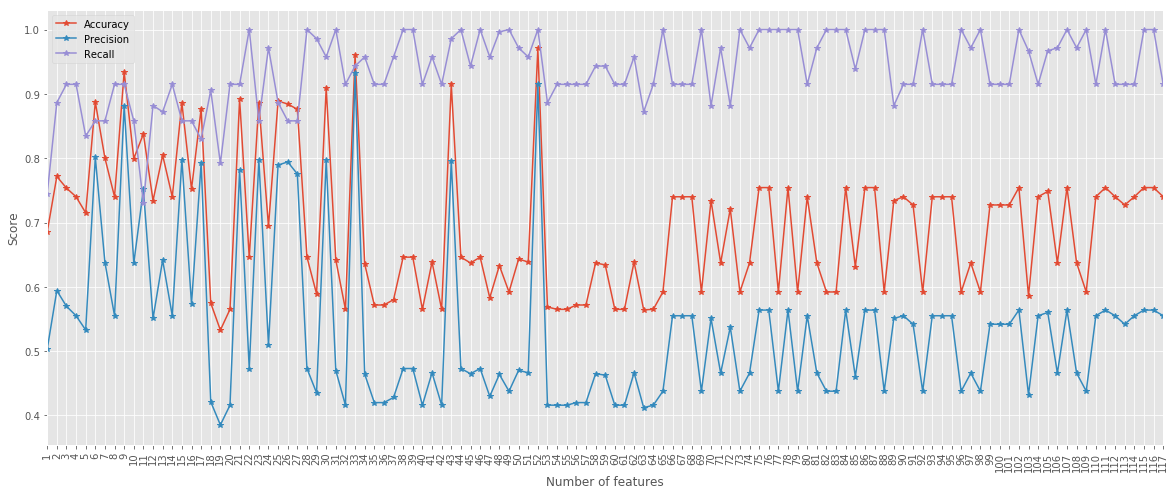

In [26]:
score = []
precision = []
recall = []
index = np.arange(1,X_dummy.shape[1]+1)
for i in index:
    clf = tree.DecisionTreeClassifier(
        criterion='gini', 
        splitter='best', 
        max_depth=None, 
        min_samples_split=2, 
        min_samples_leaf=1, 
        min_weight_fraction_leaf=0.0, 
        max_features=i, 
        random_state=42, # we override the default here for the sake of reproducibility
        max_leaf_nodes=None, 
        min_impurity_split=1e-07, 
        class_weight=None, 
        presort=False)
    tmp = test_tree(clf, X_train, X_test, Y_train, Y_test, print_res=False)
    score.append(tmp[0])
    precision.append(tmp[1])
    recall.append(tmp[2])

pd.DataFrame({'Accuracy': score, 'Precision': precision, 'Recall': recall}, index=index).plot(figsize=(20,8), marker='*')
plt.xticks(index, rotation=90)
plt.xlabel('Number of features')
plt.ylabel('Score');

Interestingly, tuning the `max_features` parameter can help us train a better model even without shuffling of the data.
With `max_features = 52` all metrics are above $0.9$.
Remember that this is using the naive splitting for training and testing!
**The take home message** here is: *default settings are nice but can be improved*.

### `max_depth`

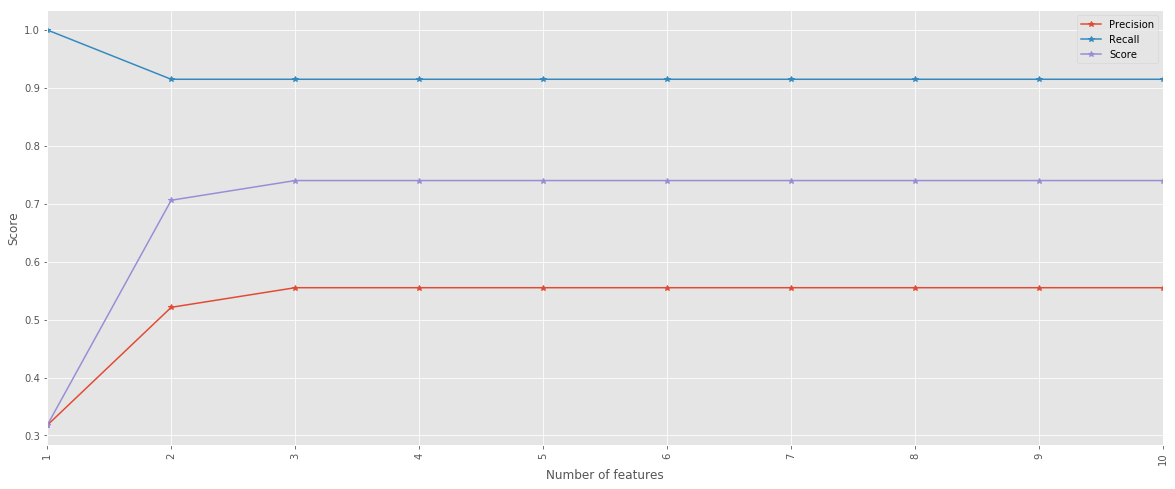

In [27]:
score = []
precision = []
recall = []
index = range(1,11)
for i in index:
    clf = tree.DecisionTreeClassifier(
        criterion='gini', 
        splitter='best', 
        max_depth=i, 
        min_samples_split=2, 
        min_samples_leaf=1, 
        min_weight_fraction_leaf=0.0, 
        max_features=None, 
        random_state=42, # we override the default here for the sake of reproducibility
        max_leaf_nodes=None, 
        min_impurity_split=1e-07, 
        class_weight=None, 
        presort=False)
    tmp = test_tree(clf, X_train, X_test, Y_train, Y_test, print_res=False)
    score.append(tmp[0])
    precision.append(tmp[1])
    recall.append(tmp[2])

pd.DataFrame({'Score': score, 'Precision': precision, 'Recall': recall}, index=index).plot(figsize=(20,8), marker='*')
plt.xticks(index, rotation=90)
plt.xlabel('Number of features')
plt.ylabel('Score');

## Visualize the tree

We conclude this post with a visualization of the tree itself.
To that end, we split the dataset and keep $0.75\%$ for training purposes.
Next, we train the tree using the defaults.

In [28]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(
        X_dummy, Y_dummy, test_size=0.75, random_state=42)

In [29]:
clf = tree.DecisionTreeClassifier(random_state=42)
clf = clf.fit(X_train, Y_train)

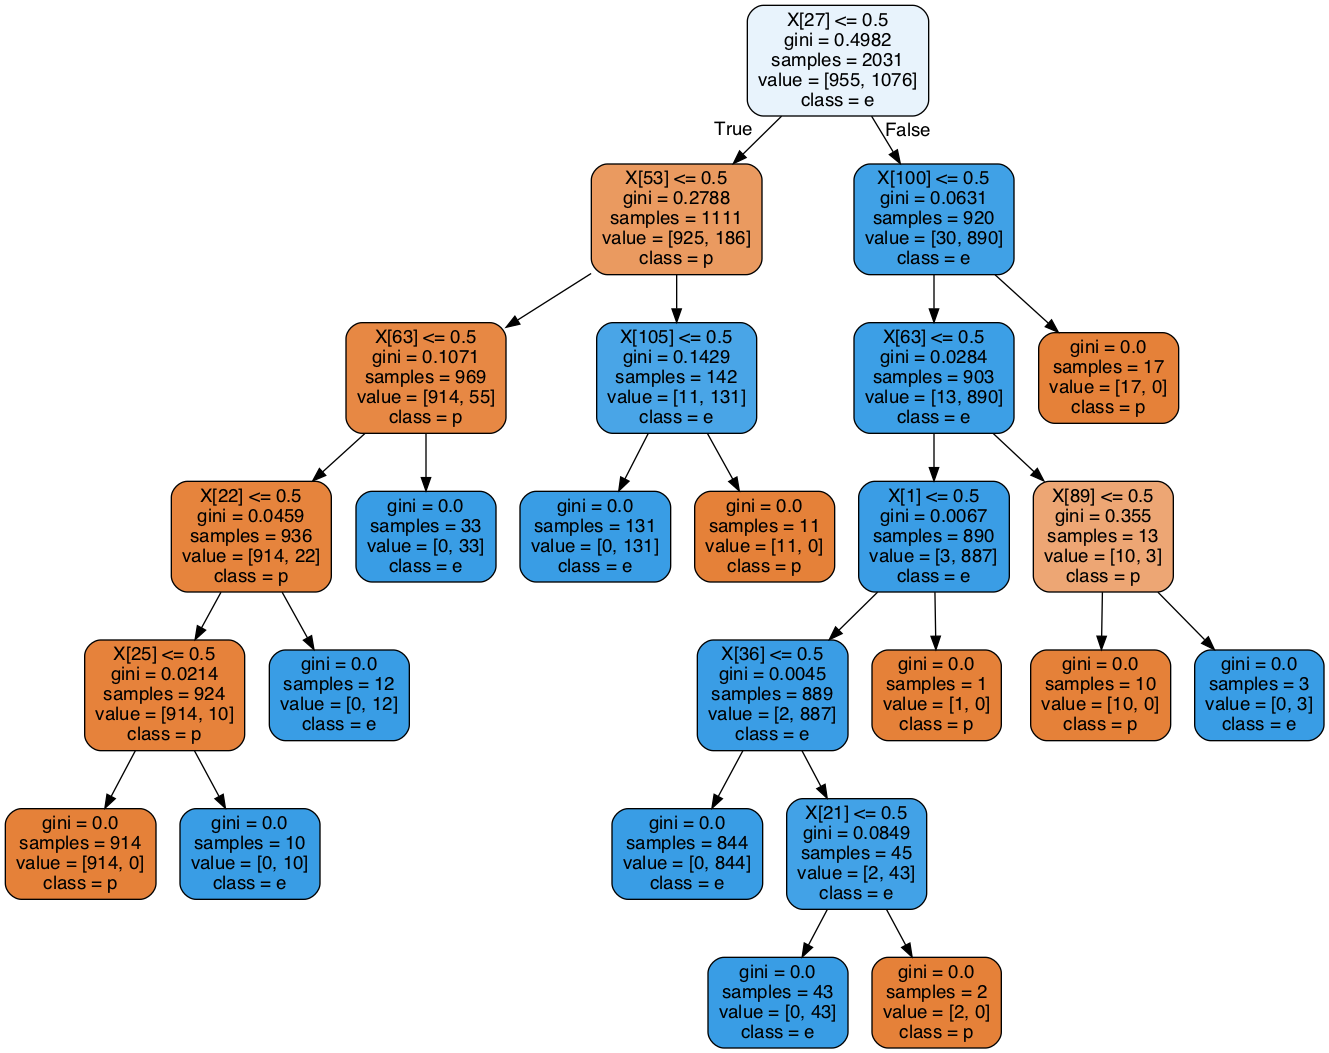

In [30]:
from sklearn import tree
from IPython.display import Image  
import pydotplus

dot_data = tree.export_graphviz(clf, out_file=None,
                                class_names=['p','e'],
                                filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

Note that there is one leaf with exactly one (poisonous) sample.
If we adjust the `min_samples_leaf` parameter and set it to $2$, we could avoid it.

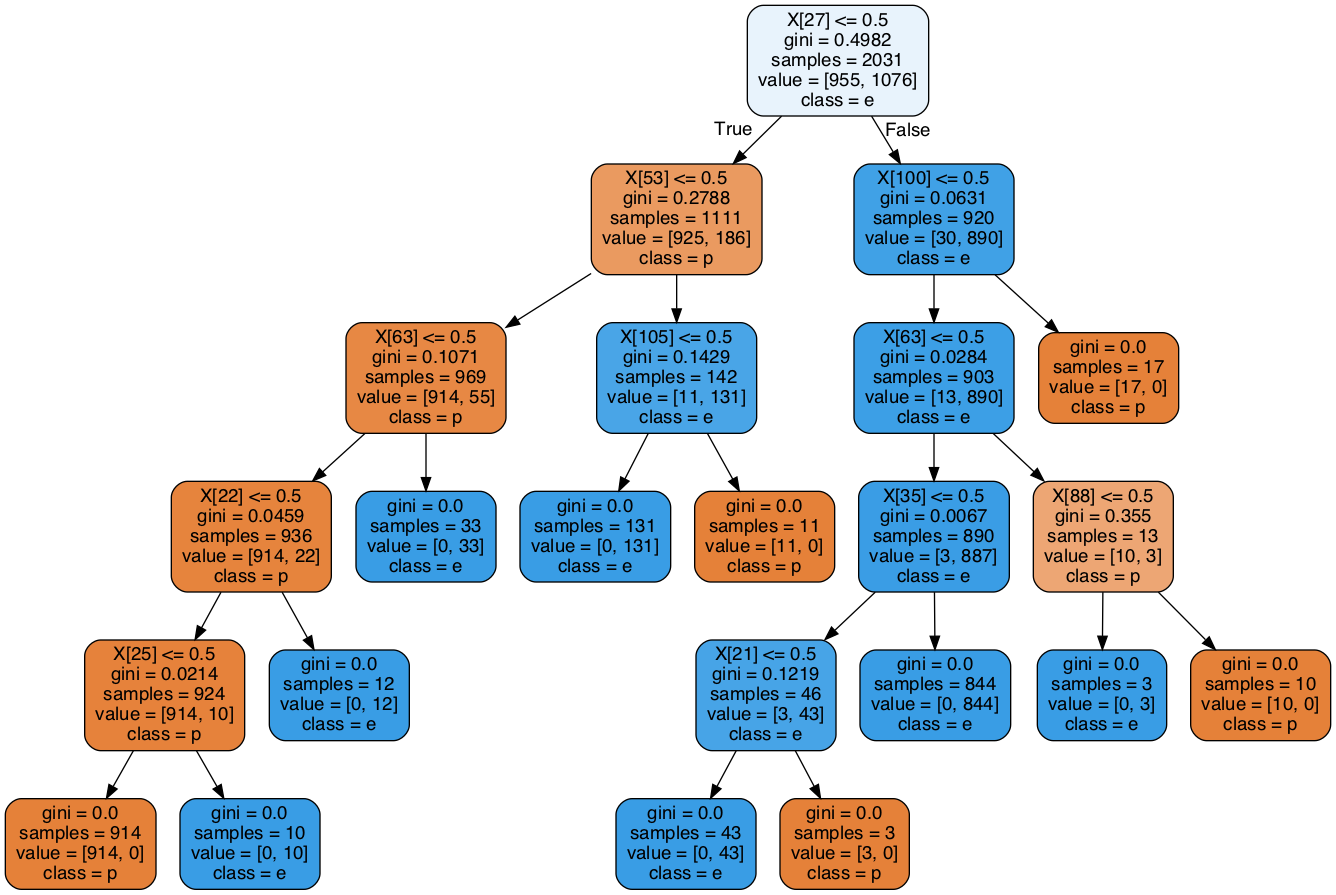

In [31]:
clf = tree.DecisionTreeClassifier(random_state=42, min_samples_leaf=2)
clf = clf.fit(X_train, Y_train)
dot_data = tree.export_graphviz(clf, out_file=None,
                                class_names=['p','e'],
                                filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [32]:
test_tree(clf, X_train, X_test, Y_train, Y_test);

Accuracy = 1.000000 / Precision = 1.000000 / Recall = 1.000000


In this specific example, there is no change in the performance of the tree; but this is a different story related to the nature of this dataset.

## Summary

This is all for this time.
You can of course continue exploration of the different tuning possibilities on your own!
This dataset is rather simple and it seems like decision trees are a good option here.
Still, trusting the trained trees with your life next time when you go and pick mushrooms is a different discussion.
If you decide to do so, the risk is all yours!

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/77/PA255433.JPG/640px-PA255433.JPG" alt="Mushroom"/>